In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./dataset/RARE.csv
./dataset/List_of_anomalies.csv


In [2]:
# import the rare dataset
rare_ds = pd.read_csv("./dataset/RARE.csv", sep="|", header=0)
rare_ds.head()
original_rare_ds = rare_ds.copy()

/Users/yolandarobla/miniforge3/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (99,100,101,370,374,378,868,869,870,2986,2987,2988,4444,4445,4446,5357,5358,5359,6151,6152,6153,7054,7055,7056) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(rare_ds.shape)

(10010, 7063)


In [4]:
rare_ds.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
import random
random.seed(42)

We can observe that we have a time series dataset, which contains the timestamp as first column, and anomaly as second column. Thee is the isntance field, that contains a descriptive value of the cluster status on that moment.
Then, there are a set of prometheus metrics, collected for the specific timestamp. The anomaly is the field that we are going to use for training, and the other entries are numerical entries, that are going to influence the model.
We have a total of 10.010 rows for training, and a total of 7063 features, that will need to be selected.
Let's show the different values for the anomaly and instance field:

In [6]:
rare_ds.columns =[col.strip() for col in rare_ds.columns]
print(rare_ds["anomaly"].unique())
print(rare_ds["instance"].unique())

[0 1]
[' Waiting for Kafka stream to start ' ' Kafka running '
 ' Generating anomaly ' ' Waiting for the script to start ']


We can see that the anomaly is just a binary field, that we can use to know if there is an anomaly or not. We can check the distribution of the field. 

array([[<AxesSubplot:title={'center':'anomaly'}>]], dtype=object)

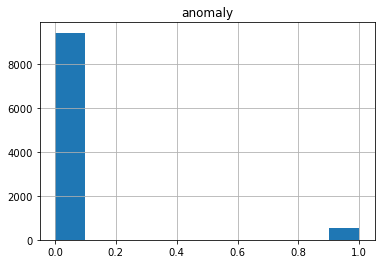

In [7]:
rare_ds.hist(column='anomaly')

About instance field, for the moment we can drop it, because it is not useful for our use case.

In [8]:
rare_ds.drop(labels=['instance'], axis=1, inplace = True)


 Now we need to proceed with feature selection. We have a total of 7060 metrics and the objective is to select the relevant ones for the project. In order to do it, we could proceed with manual removal first, using the Kubernetes domain knowledge, to discard the non meaningful ones:
 - any information about resource creation is not relevant, because it depends on the workloads that are existing on each cluster
 - kafka topics, logs... are a consequence of other operations in the cluster, they cannot be part of cluster failures reason
 - any information related about pod status, container status.. that have some fixed id needs to be discarded, as it is something that will change depending on the workloads and cluster

In [9]:
final_columns = []
for column in sorted(rare_ds.columns):
    if not column.strip().startswith(("kafka_topic", "kafka_log", "kube_configmap", "kube_namespace", "kube_service", "kube_secret", "kube_pod_status", "kube_pod_container_status", "scrape_samples", "kafka_server_brokertopic")):
        final_columns.append(column.strip())

In [10]:
features_ds = rare_ds[final_columns].copy()
features_ds.shape

(10010, 4530)

After manual selection we will use automated methods. First step would be to remove the constant features. Any metric that is having a constant value, with no relevant variance over the dataset, is a metric that is not useful to discriminate a target. We can find those constant values using variance:

In [11]:
features_ds.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [12]:
# for all columns that are objects, conver to float
for column in features_ds.columns:
    if features_ds[column].dtype == "object":
        features_ds[column] = features_ds[column].astype(float)
features_ds.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [13]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
sel.fit(features_ds)

/Users/yolandarobla/miniforge3/envs/tf_env/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.1)

In [14]:
# get a list of the constant features. Those can be removed
print(
    len([
        x for x in features_ds.columns
        if x not in features_ds.columns[sel.get_support()]
    ]))

2790


In [15]:
to_strip = [x for x in features_ds.columns if x not in features_ds.columns[sel.get_support()]]
features_ds_strip = features_ds.drop(labels=to_strip, axis=1)
features_ds_strip.shape

(10010, 1740)

With that technique we have reduced the number of features to 1740. It is still a long number of features, so we need to apply more feature reduction techniques to select the most relevant ones. As we deal with a large amount of features, we will reduce them using Mutual Information technique:

In [16]:
X = features_ds_strip
Y = rare_ds["anomaly"].to_frame()
print(X.shape)
print(Y.shape)

(10010, 1740)
(10010, 1)


In [17]:
# select with mutual information
from sklearn.feature_selection import SelectPercentile as SP
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as DTC

selector = SP(percentile=2) # select features with top 2% MI scores
selector.fit(X,Y)
X_4 = selector.transform(X)
X_train_4,X_test_4,y_train,y_test = tts(
    X_4,Y
    ,random_state=0
    ,stratify=Y
)
model_4 = DTC().fit(X_train_4,y_train)
score_4 = model_4.score(X_test_4,y_test)

/Users/yolandarobla/miniforge3/envs/tf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
print(f"score_4:{score_4}")
print(X_4.shape)

score_4:0.9896124650419497
(10010, 35)


In [19]:
# get columns, we have reduced to a total of 35
columns = np.asarray(X.columns.values)
support = np.asarray(selector.get_support())
columns_with_support = columns[support]
print(columns_with_support)

['java_lang_garbagecollector_committed_lastgcinfo_memoryusageaftergc_g1_young_generation_key_g1_eden_space_0'
 'java_lang_garbagecollector_committed_lastgcinfo_memoryusageaftergc_g1_young_generation_key_g1_old_gen_0'
 'java_lang_garbagecollector_committed_lastgcinfo_memoryusagebeforegc_g1_young_generation_key_g1_eden_space_0'
 'java_lang_garbagecollector_committed_lastgcinfo_memoryusagebeforegc_g1_young_generation_key_g1_old_gen_0'
 'java_lang_garbagecollector_used_lastgcinfo_memoryusagebeforegc_g1_young_generation_key_g1_eden_space_0'
 'java_lang_memorypool_committed_collectionusage_g1_eden_space_0'
 'java_lang_memorypool_committed_usage_g1_eden_space_0'
 'java_lang_memorypool_committed_usage_g1_old_gen_0'
 'java_lang_operatingsystem_freephysicalmemorysize_0'
 'java_lang_operatingsystem_systemloadaverage_0'
 'node_entropy_available_bits_0' 'node_filefd_allocated_0' 'node_load1_0'
 'node_load5_0' 'node_memory_Active_anon_bytes_0'
 'node_memory_Active_bytes_0' 'node_memory_Active_file_b

Using the Mutual Information method, for the 3% with bigger MI score, returned a total of 36 columns. With a more reasonable number of features, we can now use visualization to discard the highly correlated ones.

<AxesSubplot:>

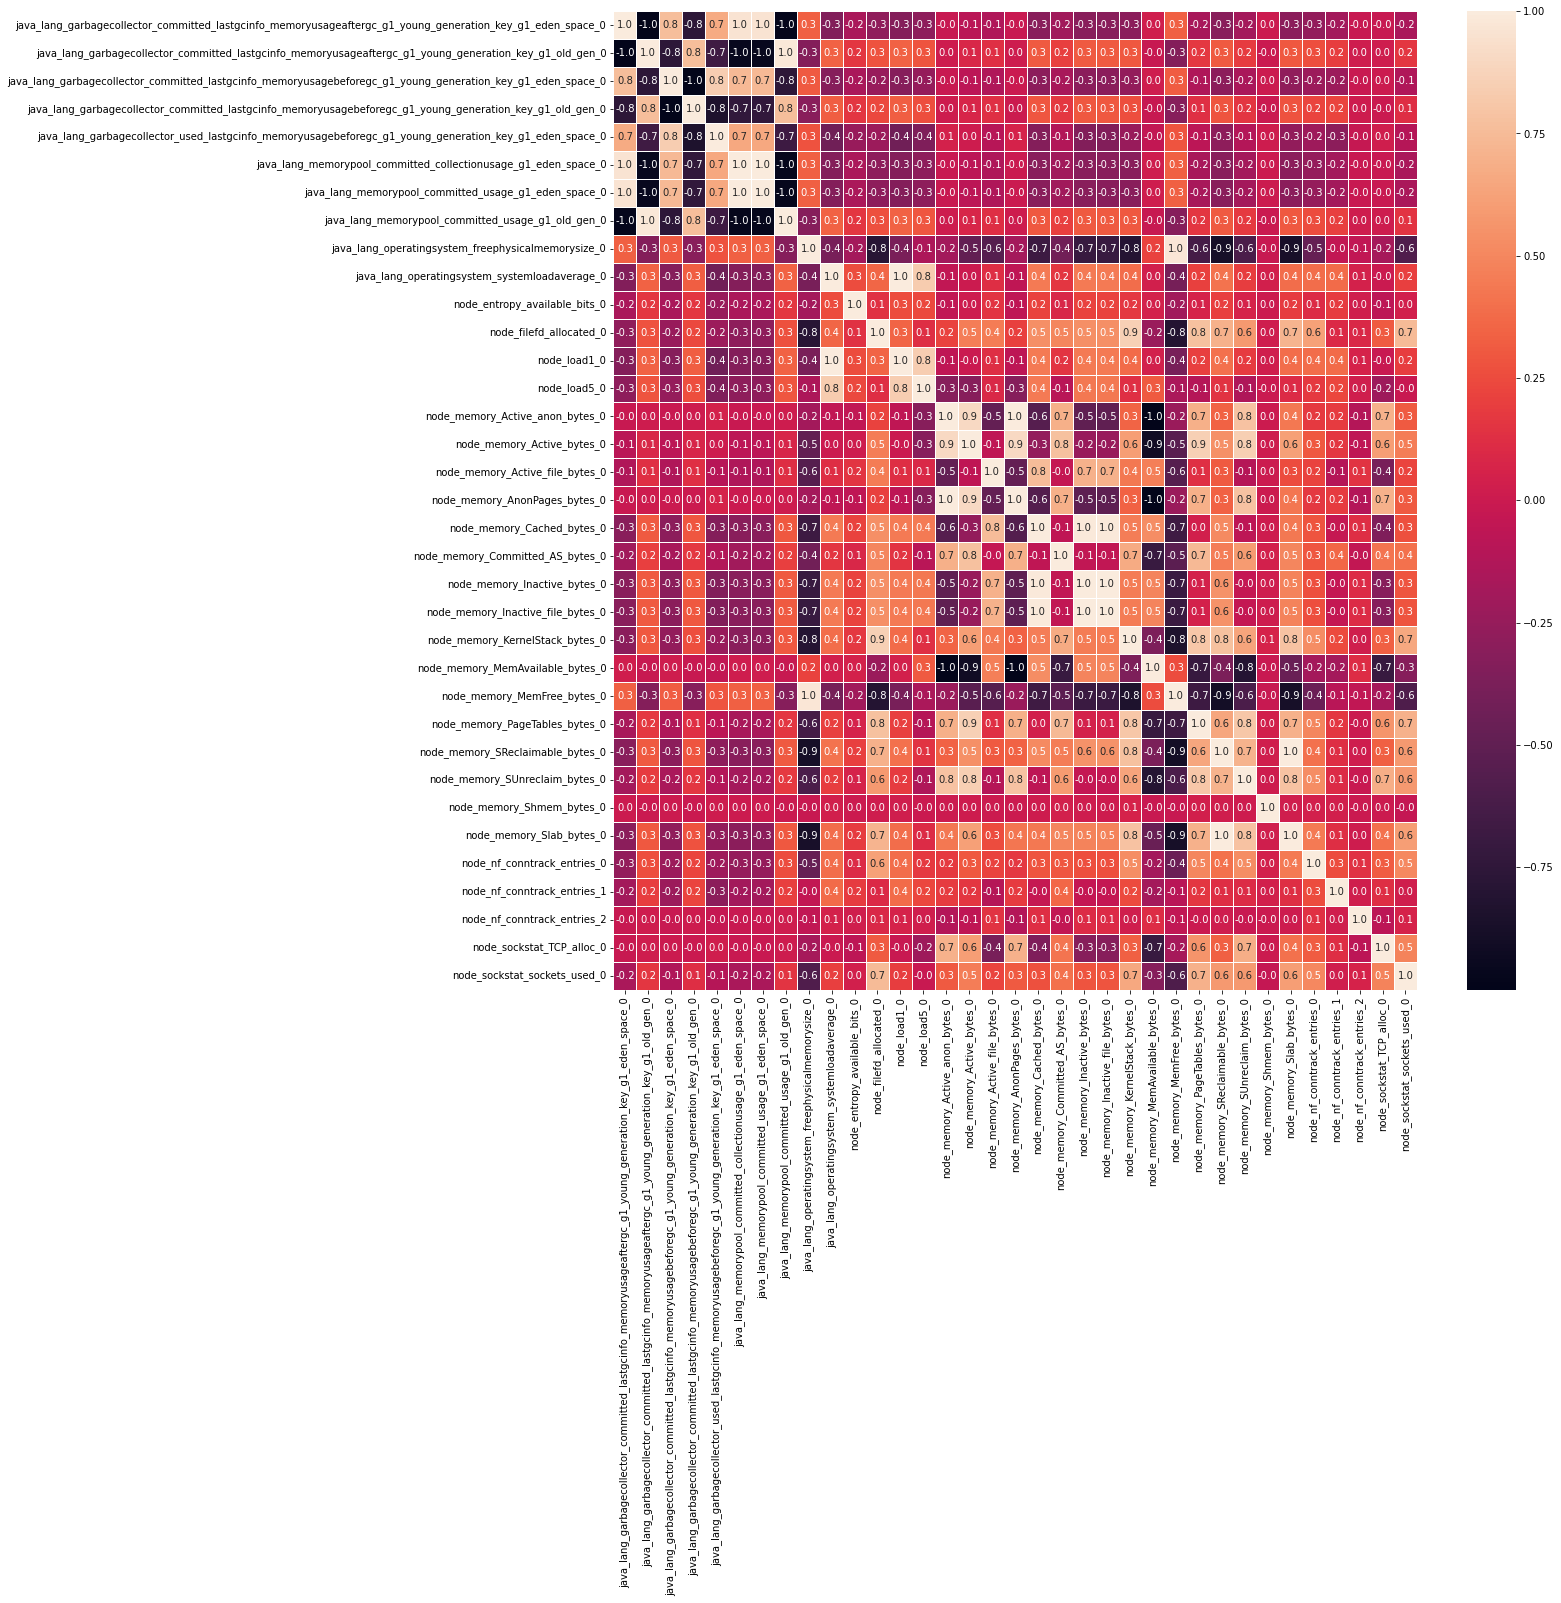

In [20]:
# with this reduced amount of features, now we can do a correlation map
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
x = rare_ds[columns_with_support]
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [21]:
common_features = ['java_lang_memorypool_committed_usage_g1_eden_space_0', 'java_lang_operatingsystem_freephysicalmemorysize_0', 'java_lang_operatingsystem_systemloadaverage_0', 'node_entropy_available_bits_0', 'node_filefd_allocated_0',
                   'node_load1_0', 'node_memory_Active_anon_bytes_0', 'node_memory_Active_file_bytes_0', 'node_memory_Cached_bytes_0', 'node_memory_Committed_AS_bytes_0', 'node_memory_Inactive_bytes_0', 'node_memory_KernelStack_bytes_0',
                   'node_memory_MemAvailable_bytes_0', 'node_memory_MemFree_bytes_0', 'node_memory_PageTables_bytes_0', 'node_memory_SReclaimable_bytes_0', 'node_memory_SUnreclaim_bytes_0', 'node_memory_Shmem_bytes_0', 'node_nf_conntrack_entries_0',
                   'node_nf_conntrack_entries_1', 'node_nf_conntrack_entries_2', 'node_sockstat_TCP_alloc_0', 'node_sockstat_sockets_used_0']

Once we have reduced the relevant features to a reasonable number, we can proceed to train the model, having in consideration that we have labeled data, in a time series format. To train it, there are several options - some of the common ones are neural networks such as LSTM. We will start by scaling the features:

In [22]:
from sklearn.preprocessing import MinMaxScaler
final_df = rare_ds[common_features]
final_df.head()

,java_lang_memorypool_committed_usage_g1_eden_space_0,java_lang_operatingsystem_freephysicalmemorysize_0,java_lang_operatingsystem_systemloadaverage_0,node_entropy_available_bits_0,node_filefd_allocated_0,node_load1_0,node_memory_Active_anon_bytes_0,node_memory_Active_file_bytes_0,node_memory_Cached_bytes_0,node_memory_Committed_AS_bytes_0,...,node_memory_MemFree_bytes_0,node_memory_PageTables_bytes_0,node_memory_SReclaimable_bytes_0,node_memory_SUnreclaim_bytes_0,node_memory_Shmem_bytes_0,node_nf_conntrack_entries_0,node_nf_conntrack_entries_1,node_nf_conntrack_entries_2,node_sockstat_TCP_alloc_0,node_sockstat_sockets_used_0
0,668991488,484511744,0.21,3424,1792,0.21,1748594688,409534464,426852352,4508262400,...,485560320,10018816,73764864,54706176,1626112,95,141,223,51,337
1,668991488,451244032,0.20,3424,1792,0.21,1748594688,409534464,426852352,4508262400,...,485560320,10018816,73764864,54706176,1626112,95,141,223,51,337
2,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,4518027264,...,455524352,11169792,74645504,55894016,1658880,138,141,223,54,344
3,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,4518027264,...,455524352,11169792,74645504,55894016,1658880,138,141,223,54,344
4,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,4518027264,...,455524352,11169792,74645504,55894016,1658880,138,141,225,54,344


In [23]:
# add the time and anomaly
final_df = pd.concat([rare_ds[['anomaly']], final_df], axis=1)
final_df.head()

,anomaly,java_lang_memorypool_committed_usage_g1_eden_space_0,java_lang_operatingsystem_freephysicalmemorysize_0,java_lang_operatingsystem_systemloadaverage_0,node_entropy_available_bits_0,node_filefd_allocated_0,node_load1_0,node_memory_Active_anon_bytes_0,node_memory_Active_file_bytes_0,node_memory_Cached_bytes_0,...,node_memory_MemFree_bytes_0,node_memory_PageTables_bytes_0,node_memory_SReclaimable_bytes_0,node_memory_SUnreclaim_bytes_0,node_memory_Shmem_bytes_0,node_nf_conntrack_entries_0,node_nf_conntrack_entries_1,node_nf_conntrack_entries_2,node_sockstat_TCP_alloc_0,node_sockstat_sockets_used_0
0,0,668991488,484511744,0.21,3424,1792,0.21,1748594688,409534464,426852352,...,485560320,10018816,73764864,54706176,1626112,95,141,223,51,337
1,0,668991488,451244032,0.20,3424,1792,0.21,1748594688,409534464,426852352,...,485560320,10018816,73764864,54706176,1626112,95,141,223,51,337
2,0,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,...,455524352,11169792,74645504,55894016,1658880,138,141,223,54,344
3,0,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,...,455524352,11169792,74645504,55894016,1658880,138,141,223,54,344
4,0,668991488,451244032,0.20,3431,1952,0.20,1756377088,421130240,444538880,...,455524352,11169792,74645504,55894016,1658880,138,141,225,54,344


Next thing will be to convert the timestamp to datetime, and then we need to prepare data to have regular intervals. We check the interval time, and we can see that we have information for over 15 hours, for one day. We can see that the data is already divided into regular intervals of one second.

The next step is to tranform this data into a time series problem. In orer to do that, first we need to decide the time window. This is where the data we dropped before - with Instance information - can be useful, because it shows the time where the failure was introduced, and the time it took to fail. Let's plot it: 

/var/folders/9g/lxt4k4057bxdxlg7sl6nlp940000gn/T/ipykernel_35003/1498996929.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  original_df['factor'] = pd.factorize(original_df["instance"])[0]


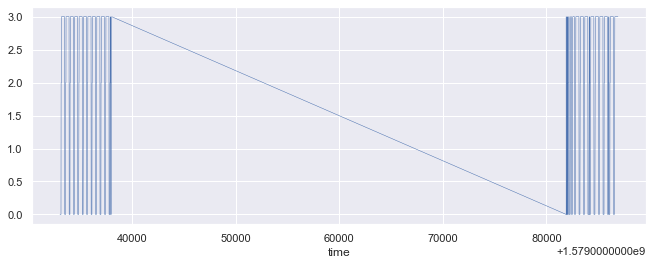

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
original_rare_ds.columns =[col.strip() for col in original_rare_ds.columns]
original_df = original_rare_ds.set_index("time")
original_df['factor'] = pd.factorize(original_df["instance"])[0]
original_df['factor'].plot(linewidth=0.5);

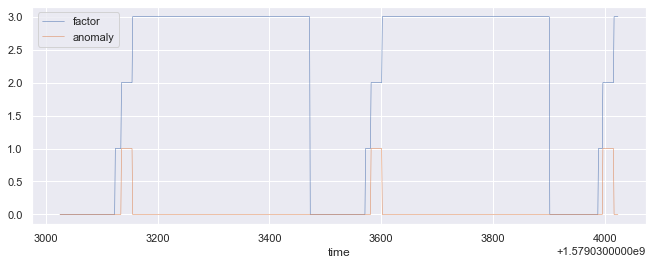

In [25]:
original_df[['factor', 'anomaly']].iloc[0:1000].plot(linewidth=0.5);

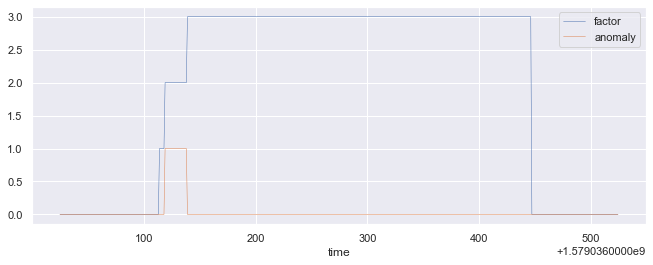

In [26]:
original_df[['factor', 'anomaly']].iloc[3000:3500].plot(linewidth=0.5);

We can see that the tests have been executed in time windows over 300 iterations, and the anomaly is just there for over 25 iterations. One good window could be to get metrics from the previous 60 iterations - that will be the previous minute:

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# integer encode direction
encoder = LabelEncoder()
values=final_df.values
values[:,1] = encoder.fit_transform(values[:,1])

In [29]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [30]:
# drop columns we don't want to predict
reframed = series_to_supervised(scaled, 120, 120)
reframed.drop(reframed.columns[list(range(len(reframed.columns)-23,len(reframed.columns)))], axis=1, inplace=True)

reframed.head()

,var1(t-120),var2(t-120),var3(t-120),var4(t-120),var5(t-120),var6(t-120),var7(t-120),var8(t-120),var9(t-120),var10(t-120),...,var16(t+118),var17(t+118),var18(t+118),var19(t+118),var20(t+118),var21(t+118),var22(t+118),var23(t+118),var24(t+118),var1(t+119)
120,0.0,0.972826,0.785907,0.031873,0.571428,0.181818,0.031873,0.329995,0.244674,0.128006,...,0.194595,0.336931,0.509228,0.003167,0.160839,0.361111,0.311111,0.5,0.543478,0.0
121,0.0,0.972826,0.722597,0.029880,0.571428,0.181818,0.031873,0.329995,0.244674,0.128006,...,0.194595,0.336931,0.509228,0.003167,0.160839,0.361111,0.511111,0.5,0.543478,0.0
122,0.0,0.972826,0.722597,0.029880,0.588096,0.636364,0.029880,0.340788,0.289548,0.150176,...,0.194595,0.336931,0.509228,0.003167,0.160839,0.472222,0.511111,0.5,0.543478,0.0
123,0.0,0.972826,0.722597,0.029880,0.588096,0.636364,0.029880,0.340788,0.289548,0.150176,...,0.194595,0.336931,0.509228,0.003167,0.160839,0.472222,0.511111,0.5,0.543478,0.0
124,0.0,0.972826,0.722597,0.029880,0.588096,0.636364,0.029880,0.340788,0.289548,0.150176,...,0.194595,0.336931,0.515100,0.003167,0.125874,0.472222,0.511111,0.5,0.521739,0.0


In [31]:
print(reframed.shape)

(9771, 5737)


In [32]:
# split into train and test sets
values = reframed.values
train_time=int(values.shape[0]*0.8)
test_time=int(values.shape[0]*0.9)

train = values[:train_time, :]
valid = values[train_time:test_time, :]
test = values[test_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(7816, 1, 5736) (7816,) (977, 1, 5736) (977,) (978, 1, 5736) (978,)


Once we have the data in the proper shape, and it is divided properly into train/validation/test, is time to start applying a model. We are going to use an LSTM model, that will be able to pick information from a sequence and will be able to learn patterns, specially if they are long sequences. 

In [33]:
# design network
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import BinaryAccuracy, AUC

model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy(),
    AUC(name='auc'), AUC(name='prc', curve='PR')])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                1157400   
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,157,921
Trainable params: 1,157,921
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit network
history1 = model1.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)

2021-12-06 12:19:49.784345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-06 12:19:49.784503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


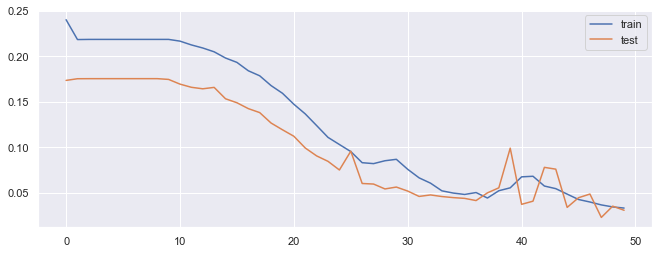

In [35]:
from matplotlib import pyplot
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

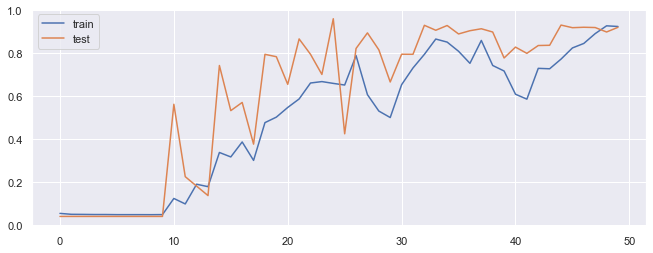

In [36]:
pyplot.plot(history1.history['prc'], label='train')
pyplot.plot(history1.history['val_prc'], label='test')
pyplot.legend()
pyplot.show()

We have plotted the chart to see the train and validation loss. We can see that is rapidly decreasing and converging. We also can see that the precision-recall finally converges around 1.

Now let's predict values with the testing data we separated from our dataset.

In [37]:
from sklearn.metrics import f1_score

scores = model1.evaluate(test_X, test_y, verbose=0)
print("Accuracy: {}".format(scores[1]))
print("AUC ROC: {}".format(scores[2]))
print("AUC precision-recall: {}".format(scores[3]))

Accuracy: 0.9795501232147217
AUC ROC: 0.9066357612609863
AUC precision-recall: 0.81292724609375


And now predict the results

In [38]:
# will be true if the probability > 0.5
from sklearn.metrics import confusion_matrix

y_pred = model1.predict(test_X)
predict_class = ((y_pred > 0.5)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[915,   3],
       [ 17,  43]])

In [39]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.8113207547169811


The model gives good results, with a very good accuracy and good PR and ROC metrics. If we execute the confusion matrix, we can se that is capable of predicting failures correctly, and is only wrong in one negative case - when there is no failure. But is not so good in the positive case, as it has predicted 10 reuslts wrong.
This problem may be due to unbalanced classes, that causes to give more importance to the negative class. One possible solution could be to play with the threshold, decreasing so it gives more predictions to 1. If we do that, we realize the the number of positive failures decreases:

In [40]:
predict_class = ((y_pred > 0.2)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[913,   5],
       [ 17,  43]])

In [41]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.7962962962962963


We have a very good model, but we have not experimented with diferent parameters or type of networks. Let's first train the first model, changing the batch size.

In [42]:
history2 = model1.fit(train_X, train_y, epochs=50, batch_size=512, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)

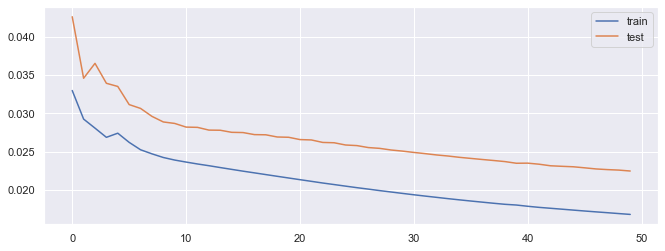

In [43]:
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

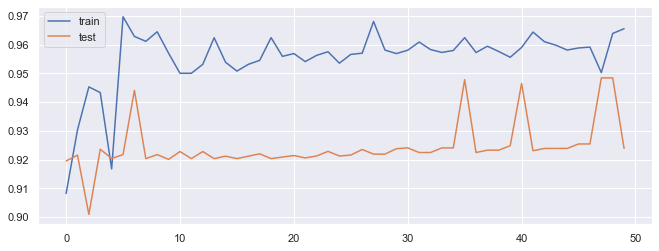

In [44]:
pyplot.plot(history2.history['prc'], label='train')
pyplot.plot(history2.history['val_prc'], label='test')
pyplot.legend()
pyplot.show()

We can see results where it took longer to converge, with inaccurate results.

In [45]:
scores = model1.evaluate(test_X, test_y, verbose=0)
print("Accuracy: {}".format(scores[1]))
print("AUC ROC: {}".format(scores[2]))
print("AUC precision-recall: {}".format(scores[3]))

Accuracy: 0.9754601120948792
AUC ROC: 0.8740558624267578
AUC precision-recall: 0.7772165536880493


In [46]:
y_pred = model1.predict(test_X)
predict_class = ((y_pred > 0.5)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[916,   2],
       [ 22,  38]])

In [47]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.7599999999999999


In [48]:
predict_class = ((y_pred > 0.2)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[916,   2],
       [ 19,  41]])

In [49]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.7961165048543688


In [50]:
model3 = Sequential()
model3.add(LSTM(units=256, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
model3.add(Dense(units=32, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy(),
    AUC(name='auc'), AUC(name='prc', curve='PR')])
model3.summary()
history3 = model3.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               6136832   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,145,089
Trainable params: 6,145,089
Non-trainable params: 0
_________________________________________________________________


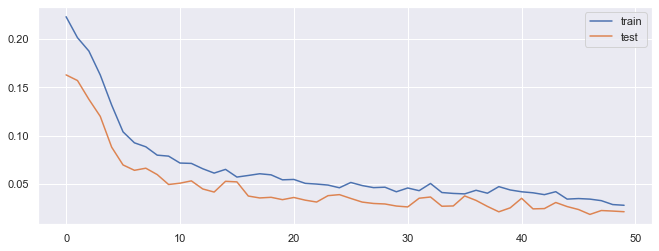

In [51]:
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

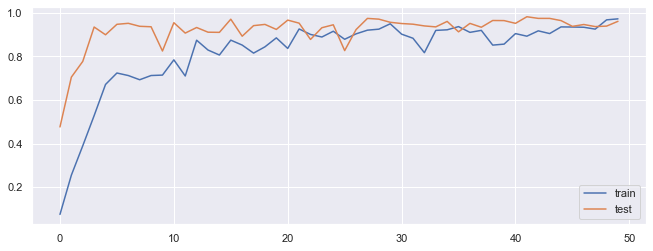

In [52]:
pyplot.plot(history3.history['prc'], label='train')
pyplot.plot(history3.history['val_prc'], label='test')
pyplot.legend()
pyplot.show()

We can see good results, where validation loss is finally converging, with some regular intervals. Let's evaluate the model to decide which one is best:

In [53]:
scores = model3.evaluate(test_X, test_y, verbose=0)
print("Accuracy: {}".format(scores[1]))
print("AUC ROC: {}".format(scores[2]))
print("AUC precision-recall: {}".format(scores[3]))

Accuracy: 0.9672801494598389
AUC ROC: 0.9683097004890442
AUC precision-recall: 0.8960035443305969


In [54]:
y_pred = model3.predict(test_X)
predict_class = ((y_pred > 0.5)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[917,   1],
       [ 31,  29]])

In [55]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.6444444444444445


In [56]:
predict_class = ((y_pred > 0.2)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[917,   1],
       [ 21,  39]])

In [57]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.78


In [58]:
model4 = Sequential()
model4.add(LSTM(units=256, return_sequences=False, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy(),
    AUC(name='auc'), AUC(name='prc', curve='PR')])
model4.summary()
history4 = model4.fit(train_X, train_y, epochs=50, batch_size=60, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               6136832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 6,137,089
Trainable params: 6,137,089
Non-trainable params: 0
_________________________________________________________________


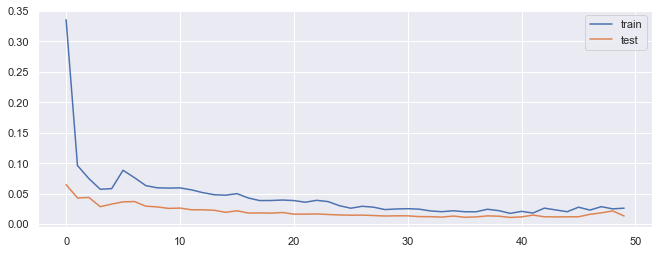

In [59]:
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

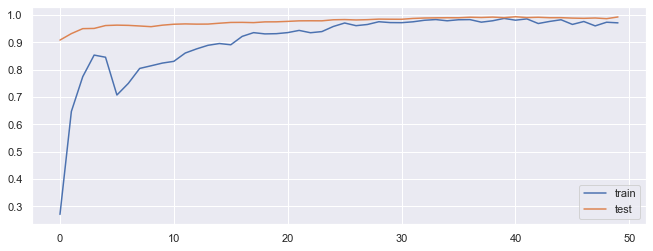

In [60]:
pyplot.plot(history4.history['prc'], label='train')
pyplot.plot(history4.history['val_prc'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
scores = model4.evaluate(test_X, test_y, verbose=0)
print("Accuracy: {}".format(scores[1]))
print("AUC ROC: {}".format(scores[2]))
print("AUC precision-recall: {}".format(scores[3]))

Accuracy: 0.9846625924110413
AUC ROC: 0.9738108515739441
AUC precision-recall: 0.9453951120376587


We can see that this model is the one that is having less validation loss, and also the numbers for Binary accuracy and Precision/Recall are better, so we will use that. Let's do a prediction with that:

In [62]:
y_pred = model4.predict(test_X)
predict_class = ((y_pred > 0.5)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[918,   0],
       [ 15,  45]])

In [63]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.8571428571428571


In [64]:
predict_class = ((y_pred > 0.2)+0).ravel()
confusion_matrix(test_y, predict_class)

array([[915,   3],
       [ 11,  49]])

In [65]:
print("F1 score: {}".format(f1_score(test_y, predict_class)))

F1 score: 0.8749999999999999


We can see that with this final model we have better results, specially on predicting the negative class. We still have some problems predicting the positive class, but if we reduce the threshold, the numbers are better.